# XGBoost (template)

July 2018
Rupert T
rup...@.....com

Derived from work at DataKind Summer Datadive 2018

* Non-functional! Template for future work only *

Summary:
.....

Model 1: Regression

Model 2: Classification


In [1]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# data import

df = pd.read_csv('xxx.csv')

### Pre-process

In [3]:
df.shape

(7349, 29)

In [ ]:
df.head()

### Exploratory analysis

(0, 0.2)

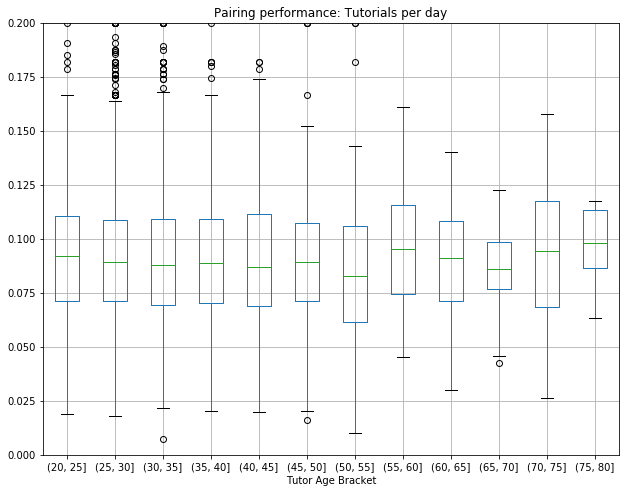

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
pairings_filtered.boxplot(column=['tut_per_day'], by='Tutor Age Bracket', ax=ax)
plt.suptitle('')
plt.title('Pairing performance: Tutorials per day')
plt.ylim((0,0.2))

### Feature engineering

### Correlations between features and target

In [29]:
from scipy.stats import pearsonr

feature_names = model_data.loc[:,feature_col_names].columns.tolist()

correlations = {}
for f in feature_names:
    data_temp = model_data[[f,target]].dropna()
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
tutor_qualification_level vs Total Happened Tutorials,0.060491
Tutor Age vs Total Happened Tutorials,0.029550
pairing_subject_first_degree vs Total Happened Tutorials,-0.027824
pairing_subject_prefered vs Total Happened Tutorials,0.004847
allocated_subject_prefered vs Total Happened Tutorials,0.001332


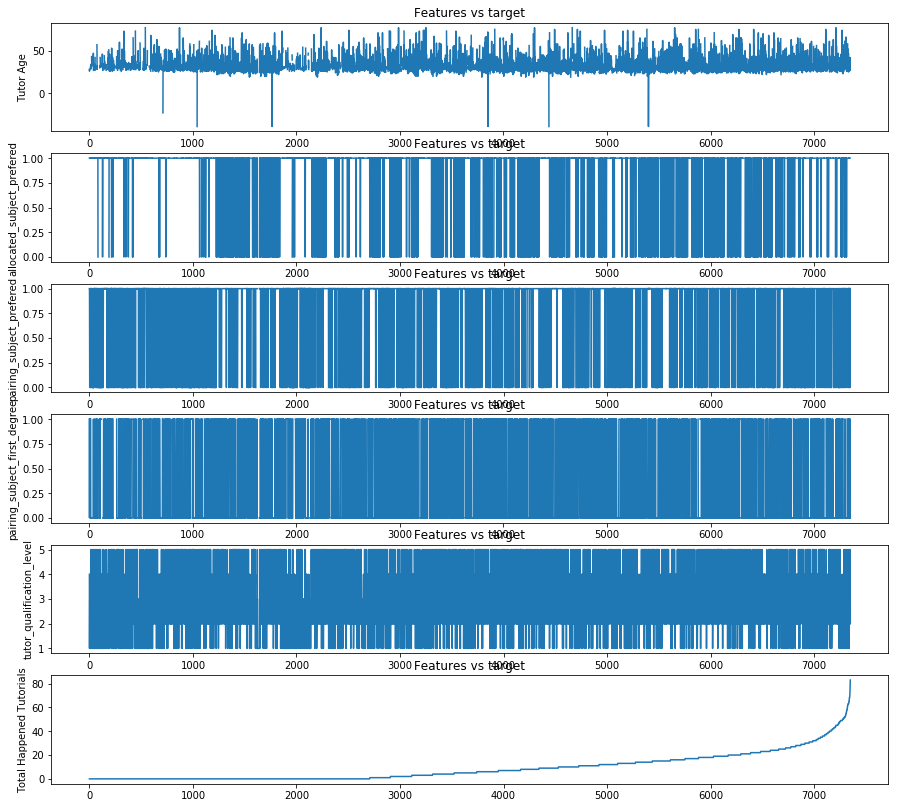

In [30]:
# Look at raw data

sorted = model_data.sort_values(target, ascending=True)#.values
idx = np.arange(sorted.shape[0])

n_cols = model_data.shape[1]

fig = plt.figure(figsize=(15,14))

for j in range(n_cols):

    plt.subplot(n_cols,1,j+1)
    plt.plot(idx,sorted.loc[:,model_col_names[j]])
    plt.title('Features vs target')
    plt.ylabel(model_col_names[j])

# plt.subplot(n_cols,1,6)
# plt.plot(idx,sorted[:,5],'r')
# plt.ylabel(target)
# plt.ylim((0,0.2))

plt.show()

### Model 1: XGBoost regression
...

In [31]:
# preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
feature_col_names = ['School Year', 'School', 'student_subject', 'Allocated Level', 'Organisation Name', 'Occupation', 'TAP priority status', 'City', 'Business partner', 'tutor_qualification_level', 'Tutor Age', 'allocated_subject_prefered', 'pairing_subject_prefered', 'pairing_subject_first_degree']
# feature_col_names = ['Tutor Age', 'allocated_subject_prefered', 'pairing_subject_prefered', 'pairing_subject_first_degree', 'tutor_qualification_level']
target = 'Total Happened Tutorials'
model_col_names = feature_col_names.copy()
model_col_names.append(target)
model_data = pairings_filtered.loc[:, model_col_names]

filtered_model_data = model_data #.loc[model_data[target]<0.2, :]

# Force to string
force_str_cols = ['School Year', 'School', 'student_subject', 'Allocated Level', 'Organisation Name', 'Occupation', 'TAP priority status', 'City', 'Business partner', 'tutor_qualification_level']
for col_name in force_str_cols:
    if col_name in filtered_model_data:
        filtered_model_data[col_name] = filtered_model_data[col_name].astype(str)

# Split into features and labels - all values even nan
X = filtered_model_data.loc[:,feature_col_names].as_matrix()
y = filtered_model_data.loc[:,[target]].as_matrix()

X.shape, y.shape

C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


((7350, 14), (7350, 1))

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encode_cols = 10  # first 6 cols

# encode string input values as integers
encoded_x = None
for i in range(0, encode_cols):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    feature = feature.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    print(feature.shape)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("enoded X shape: : ", encoded_x.shape)

all_X = np.concatenate((encoded_x, X[:,encode_cols:]), axis=1)
print("all X shape: : ", all_X.shape)

# # encode string class values as integers
# label_encoder = LabelEncoder()
# label_encoder = label_encoder.fit(Y)
# label_encoded_y = label_encoder.transform(Y)

(7350, 6)
(7350, 34)
(7350, 20)
(7350, 3)
(7350, 102)
(7350, 29)
(7350, 3)
(7350, 7)
(7350, 8)
(7350, 6)
enoded X shape: :  (7350, 218)
all X shape: :  (7350, 222)


In [34]:
# Split into test and train and validation
X_train, X_test, y_train, y_test = train_test_split(encoded_x, y, test_size=.3, random_state=42)
#X_train, X_test, y_train_with, y_test_with_id = train_test_split(X_train, y_train_with_id, test_size=.2, random_state=42)

# y_train = y_train_with_id['tut_per_day']#.as_matrix()
# y_test  = y_test_with_id['tut_per_day']#.as_matrix()
# y_valid = y_valid_with_id['tut_per_day']#.as_matrix()

(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((5145, 218), (2205, 218)), ((5145, 1), (2205, 1)))

In [35]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=15)

In [36]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [39]:
from sklearn.metrics import explained_variance_score
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

-1.3140825572273616


(0, 70)

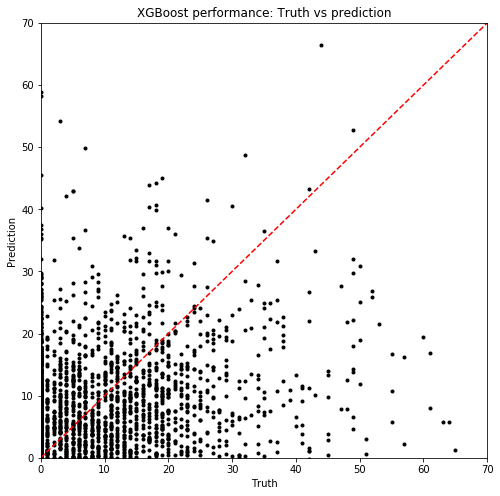

In [40]:
fig = plt.figure(figsize=(8,8))

#plt.subplot(5,1,1)
plt.plot(y_test,predictions,'k.')
plt.plot([0,70],[0,70], 'r--')
plt.title('XGBoost performance: Truth vs prediction')
plt.ylabel('Prediction')
plt.xlabel('Truth')
plt.xlim((0,70))
plt.ylim((0,70))

In [41]:
feature_scores = xgb.feature_importances_

In [42]:
feature_scores_dict = {feature_name: feature_scores[idx] for idx, feature_name in enumerate(feature_col_names)}
feature_scores_dict

{'School Year': 0.07577534,
 'School': 0.018285349,
 'student_subject': 0.022053562,
 'Allocated Level': 0.025966413,
 'Organisation Name': 0.02240374,
 'Occupation': 0.0,
 'TAP priority status': 0.0005633288,
 'City': 0.0040118145,
 'Business partner': 0.014585649,
 'tutor_qualification_level': 0.0009135062,
 'Tutor Age': 0.015742756,
 'allocated_subject_prefered': 0.009858254,
 'pairing_subject_prefered': 0.0070035476,
 'pairing_subject_first_degree': 0.0020097136}

C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


Text(0.5,0,'relative importance')

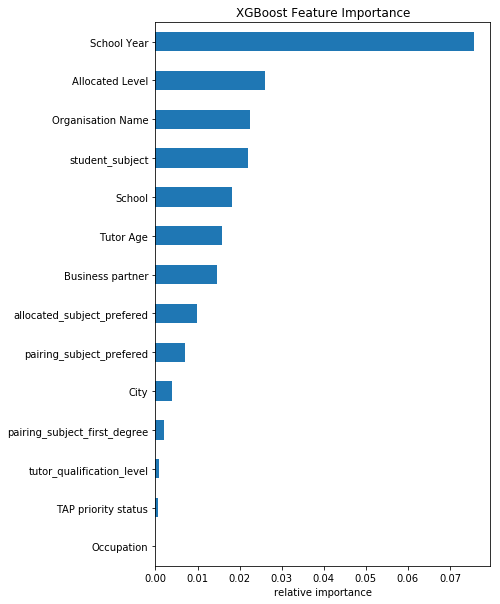

In [43]:
# Feature importance
importance_df = pd.DataFrame.from_dict(feature_scores_dict,orient='index')
importance_df.columns = ['fscore']
importance_df = importance_df.sort_values(by = 'fscore', ascending=True)
importance_df.ix[-40:,:].plot(kind='barh', legend=False, figsize=(6, 10))

plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
#plt.gcf().savefig('feature_importance_xgb.png', facecolor='w', transparent=False)

### Model 2: XGBoost classifier
...

In [44]:
feature_col_names = ['School Year', 'School', 'student_subject', 'Allocated Level', 'Organisation Name', 'Occupation', 'TAP priority status', 'City', 'Business partner', 'tutor_qualification_level', 'Tutor Age', 'allocated_subject_prefered', 'pairing_subject_prefered', 'pairing_subject_first_degree']
# feature_col_names = ['Tutor Age', 'allocated_subject_prefered', 'pairing_subject_prefered', 'pairing_subject_first_degree', 'tutor_qualification_level']

target = 'success_tut'
model_col_names = feature_col_names.copy()
model_col_names.append(target)
model_data = pairings_filtered.loc[:, model_col_names]

filtered_model_data = model_data #.loc[model_data[target]<0.2, :]

# Force to string
force_str_cols = ['School Year', 'School', 'student_subject', 'Allocated Level', 'Organisation Name', 'Occupation', 'TAP priority status', 'City', 'Business partner', 'tutor_qualification_level']
for col_name in force_str_cols:
    if col_name in filtered_model_data:
        filtered_model_data[col_name] = filtered_model_data[col_name].astype(str)



In [45]:
# Rebalance classes
balanced_model_data = pd.concat([filtered_model_data, 
                                 filtered_model_data.loc[filtered_model_data['success_tut'],:],
                                 filtered_model_data.loc[filtered_model_data['success_tut'],:]], axis=0).sample(frac=1)
balanced_model_data.shape

(11206, 15)

In [46]:
# Split into features and labels - all values even nan
X = balanced_model_data.loc[:,feature_col_names].as_matrix()
y = balanced_model_data.loc[:,[target]].as_matrix()

X.shape, y.shape

C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


((11206, 14), (11206, 1))

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encode_cols = 10  # first 6 cols

# encode string input values as integers
encoded_x = None
for i in range(0, encode_cols):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    feature = feature.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    print(feature.shape)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("enoded X shape: : ", encoded_x.shape)

all_X = np.concatenate((encoded_x, X[:,encode_cols:]), axis=1)
print("all X shape: : ", all_X.shape)

# # encode string class values as integers
# label_encoder = LabelEncoder()
# label_encoder = label_encoder.fit(Y)
# label_encoded_y = label_encoder.transform(Y)

(11206, 6)
(11206, 34)
(11206, 20)
(11206, 3)
(11206, 102)
(11206, 29)
(11206, 3)
(11206, 7)
(11206, 8)
(11206, 6)
enoded X shape: :  (11206, 218)
all X shape: :  (11206, 222)


In [48]:
# Split into test and train and validation
X_train, X_test, y_train, y_test = train_test_split(encoded_x, y, test_size=.3, random_state=42)
#X_train, X_test, y_train_with, y_test_with_id = train_test_split(X_train, y_train_with_id, test_size=.2, random_state=42)

y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((7844, 218), (3362, 218)), ((7844, 1), (3362, 1)))

In [49]:
import xgboost

xgb = xgboost.XGBClassifier(n_estimators=200, learning_rate=0.5, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=10)
xgb.fit(X_train,y_train)

pred = xgb.predict(X_test)

C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rupert.thomas\AppData\Local\Continuum\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix2(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        num_formatter = '%.1f%%'
        multiplier = 100
    else:
        print('Confusion matrix')
        num_formatter = '%d'
        multiplier = 1
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, num_formatter % (multiplier * cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[1177  450]
 [ 237 1498]]


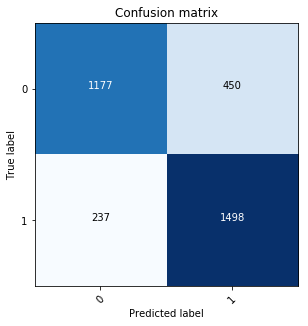

In [51]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

figure = plt.figure(figsize=(8, 8))
pred_bool = pred #(pred > 0.5) * 1
cnf_matrix = confusion_matrix(y_test, pred_bool)
class_names = ['0','1']
np.set_printoptions(precision=2)
ax = plt.subplot(122)
plot_confusion_matrix2(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize=False)

#plt.tight_layout()
plt.show()
#figure.savefig('images4/xgboost_3-way_confusion matrix_all_sensors.png', facecolor='w', transparent=False)

Normalized confusion matrix
[[0.72 0.28]
 [0.14 0.86]]


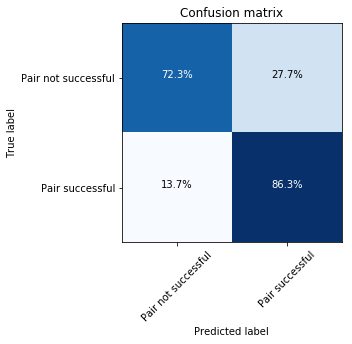

In [52]:
# Plot confusion matrix - with %
from sklearn.metrics import confusion_matrix

figure = plt.figure(figsize=(8, 8))
pred_bool = pred #(pred > 0.5) * 1
cnf_matrix = confusion_matrix(y_test, pred_bool)
class_names = ['Pair not successful','Pair successful']
np.set_printoptions(precision=2)
ax = plt.subplot(122)
plot_confusion_matrix2(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize=True)

#plt.tight_layout()
plt.show()
#figure.savefig('images4/xgboost_3-way_confusion matrix_all_sensors.png', facecolor='w', transparent=False)